<a href="https://colab.research.google.com/github/simonperrott/stockatron/blob/master/stockatron_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=d73e0622776c7ac11aff1030b665749c393251c3b8429c40c97480012c6b0e7c
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
import yfinance as yt
import numpy as np
import pandas as pd
from matplotlib import pyplot

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

pyplot.style.use("dark_background")

            Open  High   Low  Close    Volume  Dividends  Stock Splits
Date                                                                  
1999-01-04 54.61 59.33 53.31  59.16  39292200          0          0.00
1999-01-05 54.78 64.88 53.25  62.25  62873200          0          3.00
1999-01-06 68.19 70.19 67.00  69.00  36176600          0          0.00


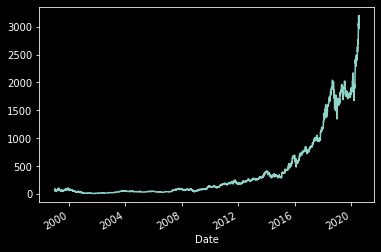

In [ ]:
amzn = yt.Ticker('AMZN')
df_amzn = amzn.history(start='1999-01-01')
print(df_amzn.head(3))
df_amzn['Close'].plot()
pyplot.show()

In [ ]:
# create the labels for each day
# 0 HOLD => -ve threshold < % Change < +ve threshold
# 1 BUY => % Change > +ve threshold
# 3 SELL => % Change < -ve threshold

def create_daily_features_and_labels(df, threshold=5):
  df['DailyChange'] = 100* (df['Close'] - df['Open'])/df['Open']
  df['DailyChange'].hist()
  pyplot.show()
  df['label'] = df['DailyChange'].apply(lambda x: 1 if x > threshold else 3 if x < -1*threshold else 0)
  # Normalise as values are in a Gaussian distribution in hist() above
  # Could also pass the dailyChange as a numpy array to StandardScalar
  df['daily_change'] = (df['DailyChange'] - df.mean()['DailyChange'])/ df.std()['DailyChange']
  print(df.tail(7))
  return df.loc[:, ['daily_change', 'label']]

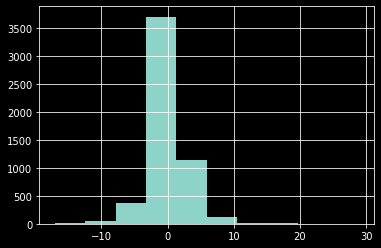

              Open    High     Low  ...  DailyChange  label  daily_change
Date                                ...                                  
2020-07-13 3251.06 3344.29 3068.39  ...        -4.52      0         -1.58
2020-07-14 3089.00 3127.38 2950.00  ...        -0.16      0         -0.08
2020-07-15 3080.23 3098.35 2973.18  ...        -2.32      0         -0.82
2020-07-16 2971.06 3032.00 2918.23  ...         0.97      0          0.30
2020-07-17 3009.00 3024.00 2948.45  ...        -1.56      0         -0.57
2020-07-20 3000.20 3201.36 2994.02  ...         6.55      1          2.22
2020-07-21 3232.49 3240.00 3105.72  ...        -3.29      0         -1.16

[7 rows x 10 columns]
********* Features with Labels **********
            daily_change  label
Date                           
2020-07-13         -1.58      0
2020-07-14         -0.08      0
2020-07-15         -0.82      0
2020-07-16          0.30      0
2020-07-17         -0.57      0
2020-07-20          2.22      1
2020-07-21   

In [ ]:
dataset = create_daily_features_and_labels(df_amzn)
print('********* Features with Labels **********')
print(dataset.tail(7))

In [ ]:
from pandas import DataFrame
from pandas import concat

def dataframe_to_supervised(df, input_cols, label_col, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a NumPy array.
    input_cols: list of strings identifying the input feature columns to use in shifting
		n_in: Number of lag observations as input (X).
		label_col: the name of the label column
    n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[input_cols].shift(i))
		names += [f'{c}(t-{i})' for c in input_cols]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[label_col].shift(-i))
		if i == 0:
			names += [f'{label_col}(t)']
		else:
			names += [f'{label_col}(t+{i})']
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# Baseline 1st Model uses:
# one feature = price daily change
# timeseries of prices going back 50 days
# predicts only 1 day forward
num_time_steps = 1
df_price_ts = dataframe_to_supervised(dataset, ['daily_change'], 'label', num_time_steps, 1)

['daily_change(t-1)', 'label(t)']


In [ ]:
print(df_price_ts.shape)
df_price_ts.tail(10)

(5421, 2)


,daily_change(t-1),label(t)
Date,,
2020-07-08,-0.69,0
2020-07-09,0.64,0
2020-07-10,0.71,0
2020-07-13,0.06,0
2020-07-14,-1.58,0
2020-07-15,-0.08,0
2020-07-16,-0.82,0
2020-07-17,0.30,0
2020-07-20,-0.57,1


In [ ]:
# Split into Train & Test
# Training 2007 - 2017
train = df_price_ts.loc['2015' :'2017'].values
train_X, train_y = train[:, :-1], train[:, -1]
# Test 2018 - now
test = df_price_ts.loc['2018' :'2020'].values
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], num_time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], num_time_steps, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(755, 1)
(755,)
(642, 1)
(642,)
(755, 1, 1) (755,) (642, 1, 1) (642,)


Using TensorFlow backend.


Train on 755 samples, validate on 642 samples
Epoch 1/50
 - 1s - loss: 0.0143 - val_loss: 0.0354
Epoch 2/50
 - 0s - loss: 0.0132 - val_loss: 0.0348
Epoch 3/50
 - 0s - loss: 0.0129 - val_loss: 0.0342
Epoch 4/50
 - 0s - loss: 0.0128 - val_loss: 0.0337
Epoch 5/50
 - 0s - loss: 0.0123 - val_loss: 0.0333
Epoch 6/50
 - 0s - loss: 0.0122 - val_loss: 0.0332
Epoch 7/50
 - 0s - loss: 0.0122 - val_loss: 0.0330
Epoch 8/50
 - 0s - loss: 0.0122 - val_loss: 0.0332
Epoch 9/50
 - 0s - loss: 0.0124 - val_loss: 0.0333
Epoch 10/50
 - 0s - loss: 0.0126 - val_loss: 0.0334
Epoch 11/50
 - 0s - loss: 0.0124 - val_loss: 0.0330
Epoch 12/50
 - 0s - loss: 0.0121 - val_loss: 0.0328
Epoch 13/50
 - 0s - loss: 0.0121 - val_loss: 0.0331
Epoch 14/50
 - 0s - loss: 0.0122 - val_loss: 0.0329
Epoch 15/50
 - 0s - loss: 0.0121 - val_loss: 0.0331
Epoch 16/50
 - 0s - loss: 0.0121 - val_loss: 0.0330
Epoch 17/50
 - 0s - loss: 0.0123 - val_loss: 0.0328
Epoch 18/50
 - 0s - loss: 0.0122 - val_loss: 0.0330
Epoch 19/50
 - 0s - loss: 0

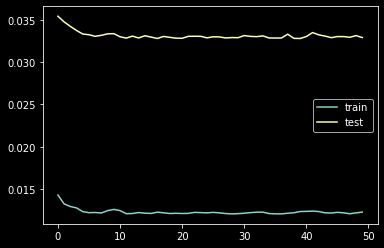

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Input features are DailyChange_n and S&P_DAilyChange_n of the day before
df_amzn['PreviousDay_Change'] = df_amzn.DailyChange_n.shift(1)
df_amzn['PreviousDay_S&P_Change'] = df_amzn['S&P_DailyChange_n'].shift(1)
# drop the first row as we don't have a previous day
df_amzn.dropna(inplace=True)
df_amzn

,Open,High,Low,Close,Volume,Dividends,Stock Splits,DailyChangePercent,DailyChange,DailyChangePercent_n,DailyChange_n,Volume_n,label,S&P_DailyChange_n,PreviousDay_Change,PreviousDay_S&P_Change
Date,,,,,,,,,,,,,,,,
1999-01-04,54.61,59.33,53.31,59.16,39292200,0,0.00,8.33,8.33,2.83,2.83,3.19,1,-0.10,0.40,-0.21
1999-01-05,54.78,64.88,53.25,62.25,62873200,0,3.00,13.64,13.64,4.66,4.66,3.97,1,1.16,2.83,-0.10
1999-01-06,68.19,70.19,67.00,69.00,36176600,0,0.00,1.19,1.19,0.38,0.38,3.05,0,1.90,4.66,1.16
1999-01-07,68.56,80.12,66.50,79.44,47274600,0,0.00,15.87,15.87,5.42,5.42,3.50,1,-0.19,0.38,1.90
1999-01-08,92.12,99.56,76.00,80.12,66662200,0,0.00,-13.03,-13.03,-4.50,-4.50,4.06,3,0.35,5.42,-0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,3251.06,3344.29,3068.39,3104.00,7720400,0,0.00,-4.52,-4.52,-1.58,-1.58,0.50,0,-1.36,0.06,0.88
2020-07-14,3089.00,3127.38,2950.00,3084.00,7231900,0,0.00,-0.16,-0.16,-0.08,-0.08,0.39,0,1.54,-1.58,-1.36
2020-07-15,3080.23,3098.35,2973.18,3008.87,5788900,0,0.00,-2.32,-2.32,-0.83,-0.83,0.03,0,-0.00,-0.08,1.54


In [ ]:
# Grab my features and label
# Shuffle
df = df_amzn[['PreviousDay_Change', 'PreviousDay_S&P_Change', 'label']]
df = df.reindex(np.random.permutation(df.index))

df

,PreviousDay_Change,PreviousDay_S&P_Change,label
Date,,,
2001-04-04,-0.34,-2.99,0
2014-05-29,0.04,-0.11,0
2001-10-18,-3.68,-1.63,0
1999-09-29,1.83,-0.09,1
2000-07-21,-0.56,0.78,0
...,...,...,...
2001-12-18,-0.93,0.85,0
2017-01-18,-0.28,-0.06,0
1999-07-15,2.03,0.27,0


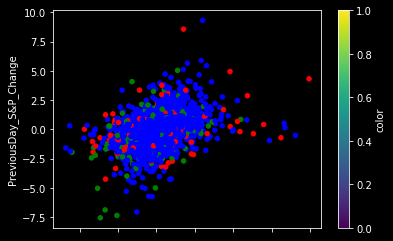

In [ ]:
# Plot the data beforehand
df['color'] = df['label'].apply(lambda x: 'blue' if x==0 else 'red' if x==3 else 'green')
df.plot.scatter(x='PreviousDay_Change', y='PreviousDay_S&P_Change', c='color')
pyplot.show()

# => A linear model cannot separate the classes!

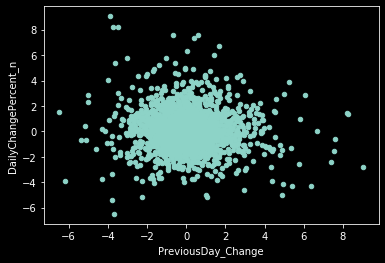

In [ ]:
# Trying a linear model based just on the Previous day's change

df.plot.scatter(x='PreviousDay_Change', y='DailyChangePercent_n')
pyplot.show()

# Still not linear. 
# Either add more features seeking a linear relationship 
# Or start my neural net

In [ ]:
# S&P500
gspc = yt.Ticker('^GSPC')
print(gspc.info)
df_gspc = gspc.history(start='1997-05-15')
df_gspc

{'previousClose': 3226.56, 'regularMarketOpen': 3208.36, 'twoHundredDayAverage': 3009.2656, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': None, 'regularMarketDayHigh': 3220.39, 'navPrice': None, 'averageDailyVolume10Day': 4701115000, 'totalAssets': None, 'regularMarketPreviousClose': 3226.56, 'fiftyDayAverage': 3116.2844, 'trailingAnnualDividendRate': None, 'open': 3208.36, 'toCurrency': None, 'averageVolume10days': 4701115000, 'expireDate': None, 'yield': None, 'algorithm': None, 'dividendRate': None, 'exDividendDate': None, 'beta': None, 'circulatingSupply': None, 'startDate': None, 'regularMarketDayLow': 3198.59, 'priceHint': 2, 'currency': 'USD', 'regularMarketVolume': 1781125025, 'lastMarket': None, 'maxSupply': None, 'openInterest': None, 'marketCap': None, 'volumeAllCurrencies': None, 'strikePrice': None, 'averageVolume': 5484843809, 'priceToSalesTrailing12Months': None, 'dayLow': 3198.59, 'ask': 3217.45, 'ytdReturn': None, 'askSize': 0, 'volume': 17811

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-14,833.13,841.29,833.13,836.04,504960000,0,0
1997-05-15,836.04,842.45,833.34,841.88,458170000,0,0
1997-05-16,841.88,841.88,829.15,829.75,486780000,0,0
1997-05-19,829.75,835.92,828.87,833.27,345140000,0,0
1997-05-20,833.27,841.96,826.41,841.66,450850000,0,0
...,...,...,...,...,...,...,...
2020-07-10,3152.47,3186.82,3136.22,3185.04,4515340000,0,0
2020-07-13,3205.08,3235.32,3149.43,3155.22,4890780000,0,0
2020-07-14,3141.11,3200.95,3127.66,3197.52,4476170000,0,0


In [ ]:
# For this I can shuffle the data before splitting into training, test & validation as I'm only looking back one day and not the timeseries context.


In [ ]:
def standardize_volume(df):
  df['Volume_n'] = np.log(df['Volume'])
  #df.hist(column='Volume_n')
  # standardize into z-scores
  df['Volume_n'] = (df['Volume_n'] - df.mean()['Volume_n'])/ df.std()['Volume_n']
  #df.plot(y='Volume_n')

In [ ]:
# Include Volume!

df_amzn.hist()
pyplot.show()
# DailyChange is Gaussian so can Standardize into z-scores
# Log Scaling for Volume (as it has a Power Law Dist) & then normalize if it has a Guassian Dist after Log Scaling.

In [ ]:
standardize_volume(df_amzn)

In [ ]:
# S&P500
gspc = yt.Ticker('^GSPC')
df_gspc = gspc.history(start='1999-01-01')
add_dailyChange(df_gspc)
add_normalized_dailyChange(df_gspc)

df_amzn['S&P_DailyChange_n'] = df_gspc['DailyChange_n']
df_amzn